In [419]:
import os
import hashlib
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.preprocessing import (
    PolynomialFeatures,
    StandardScaler,
    MinMaxScaler,
    LabelEncoder,
    OrdinalEncoder,
)
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, KFold
from sklearn.metrics import (
    mean_absolute_error,
    mean_absolute_percentage_error,
    mean_squared_error,
    root_mean_squared_error,
    r2_score,
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
)
from sklearn.linear_model import (
    LinearRegression,
    Lasso,
    Ridge,
    LassoCV,
    RidgeCV,
    LogisticRegression,
)
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from xgboost import XGBClassifier, XGBRegressor

In [420]:
RANDOM_STATE = 42

In [421]:
def hash_columns(columns):
    col_str = ",".join(sorted(columns))
    return hashlib.sha256(col_str.encode()).hexdigest()

In [422]:
def hash_series(series):
    series_str = ",".join(map(str, series.values))
    return hashlib.sha256(series_str.encode()).hexdigest()

In [423]:
def hash_data_frame(df):
    df_sorted = df.sort_index(axis=1).sort_values(by=list(df.columns))
    return hashlib.sha256(pd.util.hash_pandas_object(df_sorted, index=True).values).hexdigest()

In [424]:
def check_signature(expected, actual):
    # print(actual)
    try:
        assert actual == expected
        print("✔ Test passed!")
    except AssertionError:
        print("✘ Test failed.")
        raise

In [425]:
def test_func(func, signature):
    df = pd.read_csv("agriculture-test.csv")
    df = func(df)
    check_signature(signature, hash_data_frame(df))

In [426]:
def test_partition(func, train_X_signature, test_X_signature, train_y_signature, test_y_signature):
    df = pd.read_csv("agriculture-test.csv")
    train_X, test_X, train_y, test_y = func(df)
    try:
        # print(hash_data_frame(train_X))
        # print(hash_data_frame(test_X))
        # print(hash_series(train_y))
        # print(hash_series(test_y))
        assert hash_data_frame(train_X) == train_X_signature
        assert hash_data_frame(test_X) == test_X_signature
        assert hash_series(train_y) == train_y_signature
        assert hash_series(test_y) == test_y_signature
        print("✔ Test passed!")
    except AssertionError:
        print("✘ Test failed.")
        raise

In [427]:
def test_normalize(func, train_X_signature, test_X_signature):
    df = pd.read_csv("agriculture-test.csv")
    train_X, test_X = func(df[:80][["soil_temperature", "soil_nitrogen"]], df[80:100][["soil_temperature", "soil_nitrogen"]])
    try:
        # print(hash_data_frame(pd.DataFrame(train_X)))
        # print(hash_data_frame(pd.DataFrame(test_X)))
        assert hash_data_frame(pd.DataFrame(train_X)) == train_X_signature
        assert hash_data_frame(pd.DataFrame(test_X)) == test_X_signature
        print("✔ Test passed!")
    except AssertionError:
        print("✘ Test failed.")
        raise

In [428]:
def test_model(func, pred_y_signature):
    df = pd.read_csv("agriculture-test.csv").dropna(axis=0)
    model = func(df[:2000][["soil_moisture_index", "soil_health_index"]], df[:2000]["disease_severity"])
    model = func(train_X, train_y)
    pred_y = model.predict(train_X)
    try:
        # print(hash_series(pd.Series(pred_y)))
        assert hash_series(pd.Series(pred_y)) == pred_y_signature
        print("✔ Test passed!")
    except AssertionError:
        print("✘ Test failed.")
        raise

In [429]:
def test_evaluation(precision, recall, f1):
    try:
        assert precision > 0.70
        assert recall > 0.70
        assert f1 > 0.70
        print("✔ Test passed!")
    except AssertionError:
        print("✘ Test failed.")
        raise

In [430]:
df = pd.read_csv("agriculture.csv")

In [431]:
df.head()

,device_info,sensor_packet,sunlight_hours,soil_moisture_index,soil_health_index,irrigation_type,region,crop_variety,growth_stage,disease_severity,certification_level,yield_category
0,DEV-5026,T=13.40|N=6.97|H=58.2,1.388465,4.955898,2.807322,drip,North,Var_30,Vegetative,NaN,ISO9001,Low
1,NODE-9949,T=21.51|N=11.74|H=50.6,3.192327,3.262310,2.938019,sprinkler,South,Var_39,Seedling,No Disease,ISO9001,High
2,DEV-9932,T=27.39|N=11.14|H=58.2,2.477811,2.128176,2.295340,sprinkler,South,Var_18,Flowering,NaN,ISO9001,Medium
3,DEV-4437,T=18.97|N=8.57|H=47.3,4.197804,2.511680,1.941526,drip,South,Var_22,Flowering,No Disease,ISO9001,Low
4,DEV-9581,T=21.80|N=10.15|H=48.6,4.758862,3.436560,NaN,drip,East,Var_27,Vegetative,No Disease,ISO9001,High


In [432]:
### MANUALLY GRADED TASK
def calculate_descriptive_statistics(df):
    """
    Calculate the descriptive statistics for all numeric variables in the dataset.
    The statistics should include: count, mean, standard deviation, minimum,
    25th percentile, median, 75th percentile, and maximum.
    
    Return the result as a `pd.DataFrame`.
    """

    ### BEGIN SOLUTION
    return df.describe()
    ### END SOLUTION

In [433]:
calculate_descriptive_statistics(df)

,sunlight_hours,soil_moisture_index,soil_health_index
count,9525.000000,9292.000000,9282.000000
mean,3.929670,4.129037,2.726327
std,1.976117,1.744594,1.106538
min,0.049477,0.779627,0.000000
25%,2.430703,2.903494,1.948743
50%,3.696851,3.788847,2.603356
75%,5.175118,4.943178,3.344840
max,12.143025,15.354022,10.000000


In [434]:
### MANUALLY GRADED TASK
def plot_sunlight_hours_distribution(df):
    """
    Plot the `sunlight_hours` (distribution.->hist)

    od 04:supervised learning sns.histplot(california_housing_df["MedHouseVal"]) 
    ama moze i dr samo mislam sns da e toa e aud2 
    i hours e regre pa hist se koriste

    """

    ### BEGIN SOLUTION
    sns.histplot(df, x="sunlight_hours")
    ### END SOLUTION

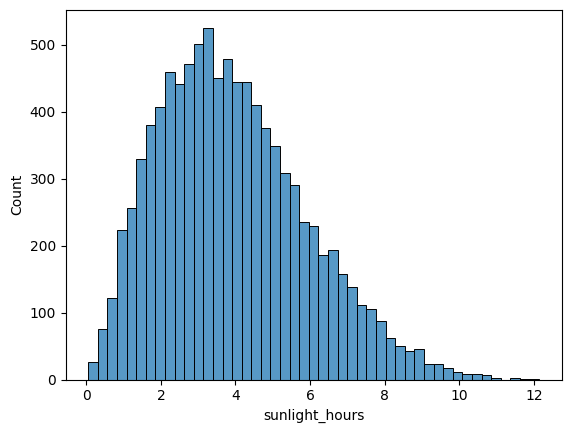

In [435]:
 plot_sunlight_hours_distribution(df)

In [436]:
### MANUALLY GRADED TASK
def plot_yield_category_distribution(df):
    """
    Plot the `yield_category` distribution.
    
    aud 2:Bar Plot
This bar plot shows how many products belong to each type.
za kategoriska kolona se koriste barplot
    """

    ### BEGIN SOLUTION
    sns.barplot(df["yield_category"].value_counts())
    ### END SOLUTION

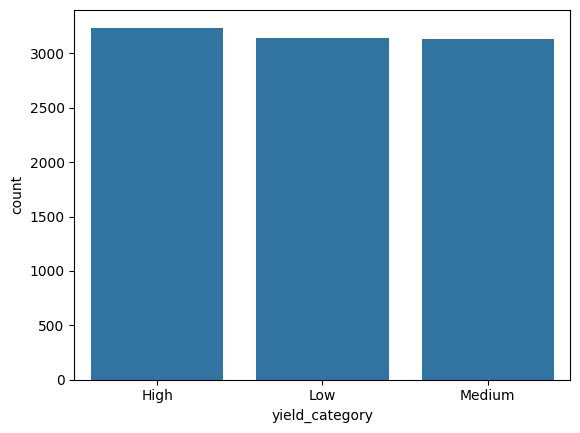

In [437]:
plot_yield_category_distribution(df)

In [438]:
### MANUALLY GRADED TASK
def plot_relationship_between_soil_moisture_index_and_soil_health_index(df):
    """
    (Plot the relationship betwee->scatter) `soil_moisture_index` and `soil_health_index`.

    sns.scatterplot(df, x="curr_price", y="prev_price")
aud 2 BUKV PISE KOE ZA SO E
    """

    ### BEGIN SOLUTION
    sns.scatterplot(df, x="soil_moisture_index", y="soil_health_index")
    ### END SOLUTION

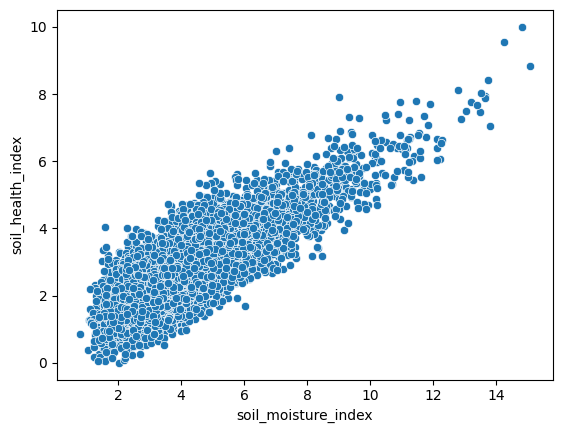

In [439]:
plot_relationship_between_soil_moisture_index_and_soil_health_index(df)

In [440]:
### MANUALLY GRADED TASK
def plot_soil_moisture_index_distribution_per_irrigation_type(df):
    """
    Plot the `soil_moisture_index` (distribution per->boxplot za rspredelba) `irrigation_type`.
    i poso ima dve spomnato znajs deka e 
    aud2 sns.boxplot(df, x="curr_price", y="type")

    """

    ### BEGIN SOLUTION
    sns.boxplot(df, x="irrigation_type", y="soil_moisture_index")
    ### END SOLUTION

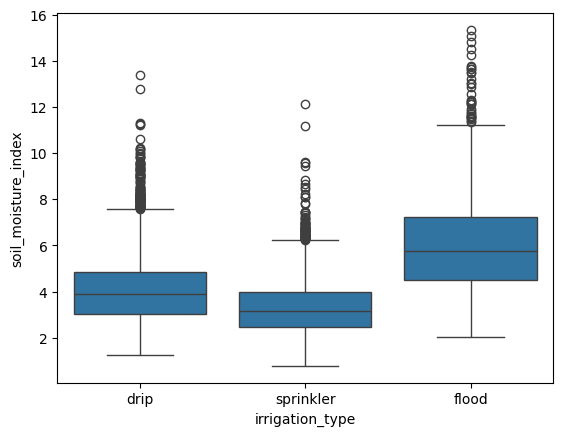

In [441]:
plot_soil_moisture_index_distribution_per_irrigation_type(df)

In [442]:
### AUTOMATICALLY GRADED TASK
def encode_or_drop_device_info(df):
    """
    EENCODE OR DROP zanci damso edno
    Encode the `device_info` variable or remove it from the dataset.

    Note: If you plan to perform one-hot encoding, use the `pd.get_dummies` function and
    append the new columns to the dataset. Also, remove the original column.
    
    Return the dataset as `pd.DataFrame`.

    DROP oti ima mn uniq vrednostoi
    """

    ### BEGIN SOLUTION
    #vezbi marija 1.2 df.drop(columns=['city'], inplace=True) ama i kaj dimitare taka 1.2 i1.1 dimi 
    #kaj ana e e isto ama kaj via 2caat e isto

    df.drop(columns=["device_info"], inplace=True)
    ### END SOLUTION
    
    return df

In [443]:
df = encode_or_drop_device_info(df)

In [444]:
### TEST
test_func(encode_or_drop_device_info, "8ac49ac49cac0b8faeb7127e61d5fcdf079c2854631cb90c1279f8dc00607e7c")
### BEGIN HIDDEN TESTS
# df.to_csv("encode_or_drop_device_info.csv")
expected_df = pd.read_csv("encode_or_drop_device_info.csv", index_col=0)
initial_df = pd.read_csv("agriculture.csv")
actual_df = encode_or_drop_device_info(initial_df)
pd.testing.assert_frame_equal(expected_df, actual_df)
### END HIDDEN TESTS

✔ Test passed!


In [445]:
### AUTOMATICALLY GRADED TASK
def parse_soil_temperature_and_soil_nitrogen_from_sensor_packet(df):
    """
    NIKADE GO NEMA I NE E JASNO,ama ako ne go napisis ne vlijae na dr 
    In the `sensor_packet` column, `T` stands for `soil_temperature` and `N` for `soil_nitrogen`.
    Parse the values for the `soil_temperature` from the `sensor_packet` column and add them as a new column named `soil_temperature`.
    Parse the values for the `soil_nitrogen` from the `sensor_packet` column and add them as a new column named `soil_nitrogen`.
    Then, remove the `sensor_packet` column from the dataset.
    
    Return the dataset as `pd.DataFrame`.
    """

    ### BEGIN SOLUTION
    df["soil_temperature"] = df["sensor_packet"].apply(lambda value: float(value.split("|")[0][2:]) if not pd.isna(value) else value)
    df["soil_nitrogen"] = df["sensor_packet"].apply(lambda value: float(value.split("|")[1][2:]) if not pd.isna(value) else value)
    df.drop(columns=["sensor_packet"], inplace=True)
    ### END SOLUTION
    
    return df

In [446]:
df = parse_soil_temperature_and_soil_nitrogen_from_sensor_packet(df)

In [447]:
### TEST
test_func(parse_soil_temperature_and_soil_nitrogen_from_sensor_packet, "ba50e222cb35706e9cb52f2d433fd53ac73b1d2c2230d8269a0baff0aea9a65a")
### BEGIN HIDDEN TESTS
def test_parse_soil_temperature_and_soil_nitrogen_from_sensor_packet():
    # df.to_csv("parse_soil_temperature_and_soil_nitrogen_from_sensor_packet.csv")
    expected_df = pd.read_csv("parse_soil_temperature_and_soil_nitrogen_from_sensor_packet.csv", index_col=0)
    initial_df = pd.read_csv("encode_or_drop_device_info.csv", index_col=0)
    actual_df = parse_soil_temperature_and_soil_nitrogen_from_sensor_packet(initial_df)
    pd.testing.assert_frame_equal(expected_df, actual_df)
test_parse_soil_temperature_and_soil_nitrogen_from_sensor_packet()
### END HIDDEN TESTS

✔ Test passed!


In [448]:
df.head()

,sunlight_hours,soil_moisture_index,soil_health_index,irrigation_type,region,crop_variety,growth_stage,disease_severity,certification_level,yield_category,soil_temperature,soil_nitrogen
0,1.388465,4.955898,2.807322,drip,North,Var_30,Vegetative,NaN,ISO9001,Low,13.40,6.97
1,3.192327,3.262310,2.938019,sprinkler,South,Var_39,Seedling,No Disease,ISO9001,High,21.51,11.74
2,2.477811,2.128176,2.295340,sprinkler,South,Var_18,Flowering,NaN,ISO9001,Medium,27.39,11.14
3,4.197804,2.511680,1.941526,drip,South,Var_22,Flowering,No Disease,ISO9001,Low,18.97,8.57
4,4.758862,3.436560,NaN,drip,East,Var_27,Vegetative,No Disease,ISO9001,High,21.80,10.15


In [449]:
### AUTOMATICALLY GRADED TASK
def encode_or_drop_irrigation_type(df):
    """
    Encode the `irrigation_type` variable or remove it from the dataset.

    Note: If you plan to perform one-hot encoding, use the `pd.get_dummies` function and
    append the new columns to the dataset. Also, remove the original column.
    
    Return the dataset as `pd.DataFrame`.

    dimi 1.2  df = pd.concat([df, pd.get_dummies(df["Brand"])], axis=1)
df.drop(columns=["Brand"], inplace=True)
skrozisto
    """

    ### BEGIN SOLUTION
    df = pd.concat([df, pd.get_dummies(df["irrigation_type"])], axis=1)
    df.drop(columns=["irrigation_type"], inplace=True)
    ### END SOLUTION
    
    return df

In [450]:
df = encode_or_drop_irrigation_type(df)

In [451]:
### TEST
test_func(encode_or_drop_irrigation_type, "c74da4bacf1c8a6e754c689933f22d2201bd45451e478ff6199eb9190f1214c0")
### BEGIN HIDDEN TESTS
def test_encode_or_drop_irrigation_type():
    # df.to_csv("encode_or_drop_irrigation_type.csv")
    expected_df = pd.read_csv("encode_or_drop_irrigation_type.csv", index_col=0)
    initial_df = pd.read_csv("parse_soil_temperature_and_soil_nitrogen_from_sensor_packet.csv", index_col=0)
    actual_df = encode_or_drop_irrigation_type(initial_df)
    pd.testing.assert_frame_equal(expected_df, actual_df)
test_encode_or_drop_irrigation_type()
### END HIDDEN TESTS

✔ Test passed!


In [452]:
df.head()

,sunlight_hours,soil_moisture_index,soil_health_index,region,crop_variety,growth_stage,disease_severity,certification_level,yield_category,soil_temperature,soil_nitrogen,drip,flood,sprinkler
0,1.388465,4.955898,2.807322,North,Var_30,Vegetative,NaN,ISO9001,Low,13.40,6.97,True,False,False
1,3.192327,3.262310,2.938019,South,Var_39,Seedling,No Disease,ISO9001,High,21.51,11.74,False,False,True
2,2.477811,2.128176,2.295340,South,Var_18,Flowering,NaN,ISO9001,Medium,27.39,11.14,False,False,True
3,4.197804,2.511680,1.941526,South,Var_22,Flowering,No Disease,ISO9001,Low,18.97,8.57,True,False,False
4,4.758862,3.436560,NaN,East,Var_27,Vegetative,No Disease,ISO9001,High,21.80,10.15,True,False,False


In [453]:
### AUTOMATICALLY GRADED TASK
def encode_or_drop_region(df):
    """
    VIA GI ENCODE OTI MALKU SE I TOA PRED NEGO I VOA ZANCI NEMA UNIQ TIA NEKOLKU SE 
    Encode the `region` variable or remove it from the dataset.

    Note: If you plan to perform one-hot encoding, use the `pd.get_dummies` function and
    append the new columns to the dataset. Also, remove the original column.
    
    Return the dataset as `pd.DataFrame`.
    """

    ### BEGIN SOLUTION
    df = pd.concat([df, pd.get_dummies(df["region"])], axis=1)
    df.drop(columns=["region"], inplace=True)
    ### END SOLUTION
    
    return df

In [454]:
df = encode_or_drop_region(df)

In [455]:
### TEST
test_func(encode_or_drop_region, "0cbb74e46f71e93de2e4aa0f7c7cd4ca31f132312d8748694718325d92ca12ac")
### BEGIN HIDDEN TESTS
def test_encode_or_drop_region():
    # df.to_csv("encode_or_drop_region.csv")
    expected_df = pd.read_csv("encode_or_drop_region.csv", index_col=0)
    initial_df = pd.read_csv("encode_or_drop_irrigation_type.csv", index_col=0)
    actual_df = encode_or_drop_region(initial_df)
    pd.testing.assert_frame_equal(expected_df, actual_df)
test_encode_or_drop_region()
### END HIDDEN TESTS

✔ Test passed!


In [456]:
df.head()

,sunlight_hours,soil_moisture_index,soil_health_index,crop_variety,growth_stage,disease_severity,certification_level,yield_category,soil_temperature,soil_nitrogen,drip,flood,sprinkler,East,North,South,West
0,1.388465,4.955898,2.807322,Var_30,Vegetative,NaN,ISO9001,Low,13.40,6.97,True,False,False,False,True,False,False
1,3.192327,3.262310,2.938019,Var_39,Seedling,No Disease,ISO9001,High,21.51,11.74,False,False,True,False,False,True,False
2,2.477811,2.128176,2.295340,Var_18,Flowering,NaN,ISO9001,Medium,27.39,11.14,False,False,True,False,False,True,False
3,4.197804,2.511680,1.941526,Var_22,Flowering,No Disease,ISO9001,Low,18.97,8.57,True,False,False,False,False,True,False
4,4.758862,3.436560,NaN,Var_27,Vegetative,No Disease,ISO9001,High,21.80,10.15,True,False,False,True,False,False,False


In [457]:
### AUTOMATICALLY GRADED TASK
def encode_or_drop_crop_variety(df):
    """
    Encode the `crop_variety` variable or remove it from the dataset.

    Note: If you plan to perform one-hot encoding, use the `pd.get_dummies` function and
    append the new columns to the dataset. Also, remove the original column.
    
    Return the dataset as `pd.DataFrame`.
    """

    ### BEGIN SOLUTION
    df.drop(columns=["crop_variety"], inplace=True)
    ### END SOLUTION
    
    return df

In [458]:
df = encode_or_drop_crop_variety(df)

In [459]:
### TEST
test_func(encode_or_drop_crop_variety, "aa2854a403fec7760b73a25e029d29139665ae84c97aac37e006601eb7aa1b11")
### BEGIN HIDDEN TESTS
def test_encode_or_drop_crop_variety():
    # df.to_csv("encode_or_drop_crop_variety.csv")
    expected_df = pd.read_csv("encode_or_drop_crop_variety.csv", index_col=0)
    initial_df = pd.read_csv("encode_or_drop_region.csv", index_col=0)
    actual_df = encode_or_drop_crop_variety(initial_df)
    pd.testing.assert_frame_equal(expected_df, actual_df)
test_encode_or_drop_crop_variety()
### END HIDDEN TESTS

✔ Test passed!


In [460]:
df.head()

,sunlight_hours,soil_moisture_index,soil_health_index,growth_stage,disease_severity,certification_level,yield_category,soil_temperature,soil_nitrogen,drip,flood,sprinkler,East,North,South,West
0,1.388465,4.955898,2.807322,Vegetative,NaN,ISO9001,Low,13.40,6.97,True,False,False,False,True,False,False
1,3.192327,3.262310,2.938019,Seedling,No Disease,ISO9001,High,21.51,11.74,False,False,True,False,False,True,False
2,2.477811,2.128176,2.295340,Flowering,NaN,ISO9001,Medium,27.39,11.14,False,False,True,False,False,True,False
3,4.197804,2.511680,1.941526,Flowering,No Disease,ISO9001,Low,18.97,8.57,True,False,False,False,False,True,False
4,4.758862,3.436560,NaN,Vegetative,No Disease,ISO9001,High,21.80,10.15,True,False,False,True,False,False,False


In [461]:
### AUTOMATICALLY GRADED TASK
def encode_or_drop_growth_stage(df):
    """
    Encode the `growth_stage` variable or remove it from the dataset.

    Note: If you plan to perform one-hot encoding, use the `pd.get_dummies` function and
    append the new columns to the dataset. Also, remove the original column.
    
    Return the dataset as `pd.DataFrame`.
    """

    ### BEGIN SOLUTION
    # df = pd.concat([df, pd.get_dummies(df["growth_stage"])], axis=1)
    # df.drop(columns=["growth_stage"], inplace=True)
    #gi dava greska zn zos

    df["growth_stage"] = df["growth_stage"].map({"Seedling": 0, "Vegetative": 1, "Flowering": 2, "Maturity": 3})
    ### END SOLUTION
    
    return df

In [462]:
df = encode_or_drop_growth_stage(df)

In [463]:
### TEST
test_func(encode_or_drop_growth_stage, "c5a7d9ba2d46d7e7a19cb3a9c8a2969e2cf3161a351c3b0fbdde6c50905b6be2")
### BEGIN HIDDEN TESTS
def test_encode_or_drop_growth_stage():
    # df.to_csv("encode_or_drop_growth_stage.csv")
    expected_df = pd.read_csv("encode_or_drop_growth_stage.csv", index_col=0)
    initial_df = pd.read_csv("encode_or_drop_crop_variety.csv", index_col=0)
    actual_df = encode_or_drop_growth_stage(initial_df)
    pd.testing.assert_frame_equal(expected_df, actual_df)
test_encode_or_drop_growth_stage()
### END HIDDEN TESTS

✔ Test passed!


In [464]:
### AUTOMATICALLY GRADED TASK
def encode_or_drop_disease_severity(df):
    """
    Encode the `disease_severity` variable or remove it from the dataset.

    Note: If you plan to perform one-hot encoding, use the `pd.get_dummies` function and
    append the new columns to the dataset. Also, remove the original column.
    
    Return the dataset as `pd.DataFrame`.
    """

    ### BEGIN SOLUTION
    
    df["disease_severity"] = df["disease_severity"].map({"No Disease": 0, "Low": 1, "Medium": 2, "High": 3})
    ### END SOLUTION
    
    return df

In [465]:
df = encode_or_drop_disease_severity(df)

In [466]:
### TEST
test_func(encode_or_drop_disease_severity, "1a6b9a1e96e8873dce4c81514a668592eb414c21952cf48e7f9e9040ff283f9e")
### BEGIN HIDDEN TESTS
def test_encode_or_drop_disease_severity():
    # df.to_csv("encode_or_drop_disease_severity.csv")
    expected_df = pd.read_csv("encode_or_drop_disease_severity.csv", index_col=0)
    initial_df = pd.read_csv("encode_or_drop_growth_stage.csv", index_col=0)
    actual_df = encode_or_drop_disease_severity(initial_df)
    pd.testing.assert_frame_equal(expected_df, actual_df)
test_encode_or_drop_disease_severity()
### END HIDDEN TESTS

✔ Test passed!


In [467]:
df.head()

,sunlight_hours,soil_moisture_index,soil_health_index,growth_stage,disease_severity,certification_level,yield_category,soil_temperature,soil_nitrogen,drip,flood,sprinkler,East,North,South,West
0,1.388465,4.955898,2.807322,1,NaN,ISO9001,Low,13.40,6.97,True,False,False,False,True,False,False
1,3.192327,3.262310,2.938019,0,0.0,ISO9001,High,21.51,11.74,False,False,True,False,False,True,False
2,2.477811,2.128176,2.295340,2,NaN,ISO9001,Medium,27.39,11.14,False,False,True,False,False,True,False
3,4.197804,2.511680,1.941526,2,0.0,ISO9001,Low,18.97,8.57,True,False,False,False,False,True,False
4,4.758862,3.436560,NaN,1,0.0,ISO9001,High,21.80,10.15,True,False,False,True,False,False,False


In [468]:
### AUTOMATICALLY GRADED TASK
def encode_or_drop_certification_level(df):
    """
    Encode the `certification_level` variable or remove it from the dataset.

    Note: If you plan to perform one-hot encoding, use the `pd.get_dummies` function and
    append the new columns to the dataset. Also, remove the original column.
    
    Return the dataset as `pd.DataFrame`.
    """
# OTI SAMO EDNO E
    ### BEGIN SOLUTION
    df.drop(columns=["certification_level"], inplace=True)
    ### END SOLUTION
    
    return df

In [469]:
df = encode_or_drop_certification_level(df)

In [470]:
### TEST
test_func(encode_or_drop_certification_level, "e09cb445333e11d7900153802f12b828dc76e419619091229cc5cc193e0084f8")
### BEGIN HIDDEN TESTS
def test_encode_or_drop_certification_level():
    # df.to_csv("encode_or_drop_certification_level.csv")
    expected_df = pd.read_csv("encode_or_drop_certification_level.csv", index_col=0)
    initial_df = pd.read_csv("encode_or_drop_disease_severity.csv", index_col=0)
    actual_df = encode_or_drop_certification_level(initial_df)
    pd.testing.assert_frame_equal(expected_df, actual_df)
test_encode_or_drop_certification_level()
### END HIDDEN TESTS

✔ Test passed!


In [471]:
### AUTOMATICALLY GRADED TASK
def encode_or_drop_yield_category(df):
    """
    Encode the `yield_category` variable or remove it from the dataset.

    Note: If you plan to perform one-hot encoding, use the `pd.get_dummies` function and
    append the new columns to the dataset. Also, remove the original column.
    
    Return the dataset as `pd.DataFrame`.
    """

    ### BEGIN SOLUTION  marija vezbi 1.1
    df["yield_category"] = df["yield_category"].map({"Low": 0, "Medium": 1, "High": 2})
    ### END SOLUTION
    
    return df

In [472]:
df = encode_or_drop_yield_category(df)

In [473]:
### TEST
test_func(encode_or_drop_yield_category, "9c81f50df87ba54eec4b47676bf393f620307833469717c92f41a4e3e45de4df")
### BEGIN HIDDEN TESTS
def test_encode_or_drop_yield_category():
    # df.to_csv("encode_or_drop_yield_category.csv")
    expected_df = pd.read_csv("encode_or_drop_yield_category.csv", index_col=0)
    initial_df = pd.read_csv("encode_or_drop_certification_level.csv", index_col=0)
    actual_df = encode_or_drop_yield_category(initial_df)
    pd.testing.assert_frame_equal(expected_df, actual_df)
test_encode_or_drop_yield_category()
### END HIDDEN TESTS

✔ Test passed!


In [474]:
df.head()

,sunlight_hours,soil_moisture_index,soil_health_index,growth_stage,disease_severity,yield_category,soil_temperature,soil_nitrogen,drip,flood,sprinkler,East,North,South,West
0,1.388465,4.955898,2.807322,1,NaN,0.0,13.40,6.97,True,False,False,False,True,False,False
1,3.192327,3.262310,2.938019,0,0.0,2.0,21.51,11.74,False,False,True,False,False,True,False
2,2.477811,2.128176,2.295340,2,NaN,1.0,27.39,11.14,False,False,True,False,False,True,False
3,4.197804,2.511680,1.941526,2,0.0,0.0,18.97,8.57,True,False,False,False,False,True,False
4,4.758862,3.436560,NaN,1,0.0,2.0,21.80,10.15,True,False,False,True,False,False,False


In [475]:
### AUTOMATICALLY GRADED TASK
def handle_missing_values_in_sunlight_hours(df):
    """
    Impute or remove the missing values from the `sunlight_hours` column.

    Use `random_state=RANDOM_STATE` to ensure reproducibility.

    Return the dataset as a `pd.DataFrame`.
    Во вакви основни ML задачи 99% очекуваат SimpleImputer, не KNN.
2. Знак од текстот на задачата
Во описот пишува:
Impute or remove the missing values from sunlight_hours
Не спомнува KNN никаде → значи наједноставното решение е ок.
    """

    ### BEGIN SOLUTION
    median_imputer = SimpleImputer(strategy="median")

    df[["sunlight_hours"]] = median_imputer.fit_transform(df[["sunlight_hours"]])
    ### END SOLUTION  data[['bmi']] = median_imputer.fit_transform(data[['bmi']]) ana vezbi 1.1
    #mesto data=df
    #ILI E SO SIMPLEIMPUTER ILI E KNN
    
    return df

In [476]:
df = handle_missing_values_in_sunlight_hours(df)

In [477]:
### TEST
test_func(handle_missing_values_in_sunlight_hours, "55a1c22d142775db7302f471be900536d1416dadc7b3ba97fc8912820e49aadb")
### BEGIN HIDDEN TESTS
def test_handle_missing_values_in_sunlight_hours():
    # df.to_csv("handle_missing_values_in_sunlight_hours.csv")
    expected_df = pd.read_csv("handle_missing_values_in_sunlight_hours.csv", index_col=0)
    initial_df = pd.read_csv("encode_or_drop_yield_category.csv", index_col=0)
    actual_df = handle_missing_values_in_sunlight_hours(initial_df)
    pd.testing.assert_frame_equal(expected_df, actual_df)
test_handle_missing_values_in_sunlight_hours()
### END HIDDEN TESTS

✔ Test passed!


In [478]:
### AUTOMATICALLY GRADED TASK
def handle_missing_values_in_soil_temperature(df):
    """
    Impute or remove the missing values from the `soil_temperature` column.

    Use `random_state=RANDOM_STATE` to ensure reproducibility.

    Return the dataset as a `pd.DataFrame`.
    """

    ### BEGIN SOLUTION
    simple_imputer = SimpleImputer(strategy="median")
    df[["soil_temperature"]] = simple_imputer.fit_transform(df[["soil_temperature"]])
    ### END SOLUTION
    
    return df

In [479]:
df = handle_missing_values_in_soil_temperature(df)

In [480]:
### TEST
test_func(handle_missing_values_in_soil_temperature, "c5f28d8e48e5761a27f0b4ab36dc6fc6c78bd431afa5cdaa915449aad2f6bdcd")
### BEGIN HIDDEN TESTS
def test_handle_missing_values_in_soil_temperature():
    # df.to_csv("handle_missing_values_in_soil_temperature.csv")
    expected_df = pd.read_csv("handle_missing_values_in_soil_temperature.csv", index_col=0)
    initial_df = pd.read_csv("handle_missing_values_in_sunlight_hours.csv", index_col=0)
    actual_df = handle_missing_values_in_soil_temperature(initial_df)
    pd.testing.assert_frame_equal(expected_df, actual_df)
test_handle_missing_values_in_soil_temperature()
### END HIDDEN TESTS

✔ Test passed!


In [481]:
df.head()

,sunlight_hours,soil_moisture_index,soil_health_index,growth_stage,disease_severity,yield_category,soil_temperature,soil_nitrogen,drip,flood,sprinkler,East,North,South,West
0,1.388465,4.955898,2.807322,1,NaN,0.0,13.40,6.97,True,False,False,False,True,False,False
1,3.192327,3.262310,2.938019,0,0.0,2.0,21.51,11.74,False,False,True,False,False,True,False
2,2.477811,2.128176,2.295340,2,NaN,1.0,27.39,11.14,False,False,True,False,False,True,False
3,4.197804,2.511680,1.941526,2,0.0,0.0,18.97,8.57,True,False,False,False,False,True,False
4,4.758862,3.436560,NaN,1,0.0,2.0,21.80,10.15,True,False,False,True,False,False,False


In [482]:
### AUTOMATICALLY GRADED TASK
def handle_missing_values_in_soil_nitrogen(df):
    """
    Impute or remove the missing values from the `soil_nitrogen` column.

    Use `random_state=RANDOM_STATE` to ensure reproducibility.

    Return the dataset as a `pd.DataFrame`.
    """

    ### BEGIN SOLUTION
    simple_imputer = SimpleImputer(strategy="median")
    df[["soil_nitrogen"]] = simple_imputer.fit_transform(df[["soil_nitrogen"]])
    ### END SOLUTION
    
    return df

In [483]:
df = handle_missing_values_in_soil_nitrogen(df)

In [484]:
### TEST
test_func(handle_missing_values_in_soil_nitrogen, "c5f28d8e48e5761a27f0b4ab36dc6fc6c78bd431afa5cdaa915449aad2f6bdcd")
### BEGIN HIDDEN TESTS
def test_handle_missing_values_in_soil_nitrogen():
    # df.to_csv("handle_missing_values_in_soil_nitrogen.csv")
    expected_df = pd.read_csv("handle_missing_values_in_soil_nitrogen.csv", index_col=0)
    initial_df = pd.read_csv("handle_missing_values_in_soil_temperature.csv", index_col=0)
    actual_df = handle_missing_values_in_soil_nitrogen(initial_df)
    pd.testing.assert_frame_equal(expected_df, actual_df)
test_handle_missing_values_in_soil_nitrogen()
### END HIDDEN TESTS

✔ Test passed!


In [485]:
df.head()

,sunlight_hours,soil_moisture_index,soil_health_index,growth_stage,disease_severity,yield_category,soil_temperature,soil_nitrogen,drip,flood,sprinkler,East,North,South,West
0,1.388465,4.955898,2.807322,1,NaN,0.0,13.40,6.97,True,False,False,False,True,False,False
1,3.192327,3.262310,2.938019,0,0.0,2.0,21.51,11.74,False,False,True,False,False,True,False
2,2.477811,2.128176,2.295340,2,NaN,1.0,27.39,11.14,False,False,True,False,False,True,False
3,4.197804,2.511680,1.941526,2,0.0,0.0,18.97,8.57,True,False,False,False,False,True,False
4,4.758862,3.436560,NaN,1,0.0,2.0,21.80,10.15,True,False,False,True,False,False,False


In [486]:
### MANUALLY GRADED TASK
def handle_missing_values_in_soil_moisture_index_and_soil_health_index(df):
    """
    Impute or remove the missing values from the 
    `soil_moisture_index` and `soil_health_index` columns.

    Return the dataset as a `pd.DataFrame`.
    dimi 1.1
    iterative_imputer = IterativeImputer()
df[cols] = iterative_imputer.fit_transform(df[cols])
    """

    ### BEGIN SOLUTION
    iterative_imputer = IterativeImputer()
    df[["soil_moisture_index", "soil_health_index"]] = iterative_imputer.fit_transform(df[["soil_moisture_index", "soil_health_index"]])
    ### END SOLUTION
    
    return df

In [487]:
df = handle_missing_values_in_soil_moisture_index_and_soil_health_index(df)
# df.to_csv("handle_missing_values_in_soil_moisture_index_and_soil_health_index.csv")

In [488]:
df.head()

,sunlight_hours,soil_moisture_index,soil_health_index,growth_stage,disease_severity,yield_category,soil_temperature,soil_nitrogen,drip,flood,sprinkler,East,North,South,West
0,1.388465,4.955898,2.807322,1,NaN,0.0,13.40,6.97,True,False,False,False,True,False,False
1,3.192327,3.262310,2.938019,0,0.0,2.0,21.51,11.74,False,False,True,False,False,True,False
2,2.477811,2.128176,2.295340,2,NaN,1.0,27.39,11.14,False,False,True,False,False,True,False
3,4.197804,2.511680,1.941526,2,0.0,0.0,18.97,8.57,True,False,False,False,False,True,False
4,4.758862,3.436560,2.359366,1,0.0,2.0,21.80,10.15,True,False,False,True,False,False,False


In [489]:
### MANUALLY GRADED TASK
def handle_missing_values_in_disease_severity(df):
    """
    Impute the missing values in the `disease_severity` column using `KNNImputer` with 5 neighbors.
    Use `soil_moisture_index` and `soil_health_index` for imputation.

    Return the dataset as a `pd.DataFrame`.
    TI KAZUVA KOGA KNN 
    mara 1.1
    imputer = KNNImputer(n_neighbors=3)
imputed = imputer.fit_transform(scaled)

Зошто ставаме .round() иако не е експлицитно кажано?
KNNImputer секогаш враќа float вредности, дури и кога колоната е категоријална/ordinal.
    """

    ### BEGIN SOLUTION
    knn_imputer = KNNImputer(n_neighbors=5)
    df[["disease_severity", "soil_moisture_index", "soil_health_index"]] = knn_imputer.fit_transform(df[["disease_severity", "soil_moisture_index", "soil_health_index"]])
    #df["disease_severity"] = df["disease_severity"].round()
    ### END SOLUTION
    
    return df

In [490]:
df = handle_missing_values_in_disease_severity(df)
# df.to_csv("handle_missing_values_in_disease_severity.csv")

In [491]:
df.head()

,sunlight_hours,soil_moisture_index,soil_health_index,growth_stage,disease_severity,yield_category,soil_temperature,soil_nitrogen,drip,flood,sprinkler,East,North,South,West
0,1.388465,4.955898,2.807322,1,0.0,0.0,13.40,6.97,True,False,False,False,True,False,False
1,3.192327,3.262310,2.938019,0,0.0,2.0,21.51,11.74,False,False,True,False,False,True,False
2,2.477811,2.128176,2.295340,2,0.4,1.0,27.39,11.14,False,False,True,False,False,True,False
3,4.197804,2.511680,1.941526,2,0.0,0.0,18.97,8.57,True,False,False,False,False,True,False
4,4.758862,3.436560,2.359366,1,0.0,2.0,21.80,10.15,True,False,False,True,False,False,False


In [492]:
### AUTOMATICALLY GRADED TASK
def handle_missing_values_in_yield_category(df):
    """
    Impute or remove the missing values from the `yield_category` column.

    Use `random_state=RANDOM_STATE` to ensure reproducibility.

    Return the dataset as a `pd.DataFrame`.

    Клучната причина: yield_category е ТАРГЕТ (label)***************************I E DROPNA NE DROP
    i isto podeole u split ima koa e target
    """

    ### BEGIN SOLUTION 1.2 dimi df.dropna(subset=["Price (Euro)"], axis=0, inplace=True)
    df.dropna(subset=["yield_category"], axis=0, inplace=True)
    ### END SOLUTION
    
    return df

In [493]:
df = handle_missing_values_in_yield_category(df)

In [494]:
### TEST
test_func(handle_missing_values_in_yield_category, "d8896a1453fccfa7a4d62041539d0f650d33b2e713077c1090a273ca4e74327e")
### BEGIN HIDDEN TESTS
def test_handle_missing_values_in_yield_category():
    # df.to_csv("handle_missing_values_in_yield_category.csv")
    expected_df = pd.read_csv("handle_missing_values_in_yield_category.csv", index_col=0)
    initial_df = pd.read_csv("handle_missing_values_in_disease_severity.csv", index_col=0)
    actual_df = handle_missing_values_in_yield_category(initial_df)
    pd.testing.assert_frame_equal(expected_df, actual_df)
test_handle_missing_values_in_yield_category()
### END HIDDEN TESTS

✔ Test passed!


In [495]:
### AUTOMATICALLY GRADED TASK
def split_dataset_into_train_and_test(df):
    """
    Split the dataset into features `X` and target `y`, where the target is `yield_category`.
    Then, divide `X` and `y` into training and test sets using a 75:25 ratio.

    Use `random_state=RANDOM_STATE` to ensure reproducibility.
    
    Return `train_X`, `test_X`, `train_y`, and `test_y`.

    dimi 1.2 
    X, y = df.drop(columns=["Price (Euro)"]), df["Price (Euro)"]
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2)
    """

    ### BEGIN SOLUTION
    X, y = df.drop(columns=["yield_category"]), df["yield_category"]
    train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE)
    ### END SOLUTION
    
    return train_X, test_X, train_y, test_y

In [496]:
train_X, test_X, train_y, test_y = split_dataset_into_train_and_test(df)

In [497]:
### TEST
test_partition(
    split_dataset_into_train_and_test,
    "8c12b6bd374d49cbe9bb8ef1e2182ea8c1588befad742d046762667c4cd048f3",
    "ff15120ac8e98d9692d8b43450a6d040f5adb75b85cc0c09618ebf1681484d45",
    "3add13a38ee06c5db16216e3acaa9f59674f2b03c99f83f0c695967f1bd3baf6",
    "e434719ef8eab3e6491ecaed9fc153ebd8631a289800873a0bcae33303bf211c",
)
### BEGIN HIDDEN TESTS
def test_split_dataset_into_train_and_test():
    # train_X.to_csv("partition_train_X.csv")
    # test_X.to_csv("partition_test_X.csv")
    # train_y.to_csv("partition_train_y.csv")
    # test_y.to_csv("partition_test_y.csv")
    expected_train_X = pd.read_csv("partition_train_X.csv", index_col=0)
    expected_test_X = pd.read_csv("partition_test_X.csv", index_col=0)
    expected_train_y = pd.read_csv("partition_train_y.csv", index_col=0)
    expected_test_y = pd.read_csv("partition_test_y.csv", index_col=0)
    initial_df = pd.read_csv("handle_missing_values_in_yield_category.csv", index_col=0)
    actual_train_X, actual_test_X, actual_train_y, actual_test_y = split_dataset_into_train_and_test(initial_df)
    pd.testing.assert_frame_equal(expected_train_X, actual_train_X)
    pd.testing.assert_frame_equal(expected_test_X, actual_test_X)
    pd.testing.assert_series_equal(expected_train_y["yield_category"], actual_train_y)
    pd.testing.assert_series_equal(expected_test_y["yield_category"], actual_test_y)
test_split_dataset_into_train_and_test()
### END HIDDEN TESTS

✔ Test passed!


In [498]:
### AUTOMATICALLY GRADED TASK
def normalize_features(train_X, test_X):
    """
    Normalize the features in `train_X` and `test_X`.

    Return `train_X` and `test_X`.

    zanci STANDARD SCALER

1.1 maara

train_X = scaler.fit_transform(train_X)
test_X = scaler.transform(test_X)
ama nema prv redot

    
    """

    ### BEGIN SOLUTION
    scaler = StandardScaler()
    train_X = scaler.fit_transform(train_X)
    test_X = scaler.transform(test_X)
    ### END SOLUTION
    
    return train_X, test_X

In [499]:
train_X, test_X = normalize_features(train_X, test_X)

In [500]:
### TEST
test_normalize(
    normalize_features,
    "9c7f797278f4b1776971b67c8ecfdb326a48e2de692f6456ebc9e1e4c928b4e7",
    "05e81ad9f0a71974711740dbe96684b122c2a37b36556772d5c6a4c0e939740a",
)
### BEGIN HIDDEN TESTS
def test_normalize_features():
    # pd.DataFrame(train_X).to_csv("normalize_train_X.csv")
    # pd.DataFrame(test_X).to_csv("normalize_test_X.csv")
    expected_train_X = pd.read_csv("normalize_train_X.csv", index_col=0)
    expected_test_X = pd.read_csv("normalize_test_X.csv", index_col=0)
    initial_train_X = pd.read_csv("partition_train_X.csv", index_col=0)
    initial_test_X = pd.read_csv("partition_test_X.csv", index_col=0)
    actual_train_X, actual_test_X = normalize_features(initial_train_X, initial_test_X)
    np.testing.assert_almost_equal(expected_train_X, actual_train_X, decimal=4)
    np.testing.assert_almost_equal(expected_test_X, actual_test_X, decimal=4)
test_normalize_features()
### END HIDDEN TESTS

✔ Test passed!


In [501]:
### AUTOMATICALLY GRADED TASK
def fit_model(train_X, train_y):
    """
    Fit a bagging tree-based model to predict `y` using `X` with 150 estimators and a maximum depth of 10.

    Use `random_state=RANDOM_STATE` to ensure reproducibility.

    Return the fitted model.
    regressor = RandomForestRegressor(
    n_estimators=100,
).fit(train_X, train_y) dimi 1.2
    """

    ### BEGIN SOLUTION
    model = RandomForestClassifier(
        n_estimators=150,
        max_depth=10,
        random_state=RANDOM_STATE,
    ).fit(train_X, train_y)
    ### END SOLUTION
    
    return model

In [502]:
model = fit_model(train_X, train_y)
pred_y = model.predict(test_X)

In [503]:
### TEST
test_model(fit_model, "c8cc7d145a47858910a7d06b734c4834fdb18b1da4693c5aa3e0859fae206af8")
### BEGIN HIDDEN TESTS
def test_fit_model():
    # pd.DataFrame(pred_y, columns=["yield_category"]).to_csv("pred_y.csv")
    expected_pred_y = pd.read_csv("pred_y.csv", index_col=0)["yield_category"]
    initial_train_X = pd.read_csv("normalize_train_X.csv", index_col=0)
    initial_test_X = pd.read_csv("normalize_test_X.csv", index_col=0)
    initial_train_y = pd.read_csv("partition_train_y.csv", index_col=0)["yield_category"]
    initial_test_y = pd.read_csv("partition_test_y.csv", index_col=0)["yield_category"]
    actual_model = fit_model(initial_train_X, initial_train_y)
    actual_pred_y = actual_model.predict(initial_test_X)
    np.testing.assert_almost_equal(expected_pred_y, actual_pred_y, decimal=4)
test_fit_model()
### END HIDDEN TESTS

✘ Test failed.


AssertionError: 

In [ ]:
### AUTOMATICALLY GRADED TASK
def evaluate_model(test_y, pred_y):
    """
    Evaluate the model using precision, recall, and F1-score, with a weighted average.

    Return `precision`, `recall`, and `f1`.
    """
    
    ### BEGIN SOLUTION GO NEMA NIKADE ************
    precision = precision_score(test_y, pred_y, average="weighted")
    recall = recall_score(test_y, pred_y, average="weighted")
    f1 = f1_score(test_y, pred_y, average="weighted")
    ### END SOLUTION

    return round(precision, 2), round(recall, 2), round(f1, 2)

In [ ]:
precision, recall, f1 = evaluate_model(test_y, pred_y)

In [ ]:
### TEST
test_evaluation(precision, recall, f1)
### BEGIN HIDDEN TESTS
def test_precision_recall_f1():
    initial_test_y = pd.read_csv("partition_test_y.csv", index_col=0)["yield_category"]
    initial_pred_y = pd.read_csv("pred_y.csv", index_col=0)["yield_category"]
    actual_precision, actual_recall, actual_f1 = evaluate_model(initial_test_y, initial_pred_y)
    assert actual_precision > 0.70
    assert actual_recall > 0.70
    assert actual_f1 > 0.70
test_precision_recall_f1()
### END HIDDEN TESTS